In [5]:
import uuid
import os, glob
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from seaborn import heatmap, color_palette
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
def rename_images():
    for i, file in enumerate(glob.glob('data/*/*.*')):
        new_file_name = str(uuid.uuid4()) + '.jpg'
        new_file_path = os.path.join(os.path.dirname(file), new_file_name)
        os.rename(file, new_file_path)

In [7]:
dataset_dir = 'data'

width = 224
height = 224

target_size = (width, height)
input_shape = (width, height, 3)

In [9]:
def preprocessing_function(img):
    img = tf.keras.applications.xception.preprocess_input(img)
    return img

def image_data_generator():
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                    rotation_range = 30,
                                                                    shear_range = 0.3,
                                                                    zoom_range = 0.3,
                                                                    width_shift_range=0.3,
                                                                    height_shift_range=0.3,
                                                                    horizontal_flip = True,
                                                                    preprocessing_function=preprocessing_function
                                                                    )

    train_generator = train_datagen.flow_from_directory(
                                                        dataset_dir,
                                                        target_size = target_size,
                                                        color_mode = 'rgb',
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        subset='training',
                                                        shuffle = True
                                                        )
    return train_generator

In [10]:
train_generator = image_data_generator()

Found 657 images belonging to 4 classes.


In [10]:
def sea_cucumber_detector():    
    functional_model = tf.keras.applications.Xception(
                                                     weights="imagenet",
                                                     include_top=False
                                                     )
    functional_model.trainable = True
    
    inputs = tf.keras.Input(shape=input_shape)
    x = functional_model(inputs, training=True)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    return model

In [11]:
model = sea_cucumber_detector()
model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=[
                tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ])

if not os.path.exists('sea_cucumber_detector.h5'):
    history = model.fit(
                train_generator,
                steps_per_epoch = train_generator.samples // train_generator.batch_size,
                epochs = 100,
                callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                                                    monitor='loss',
                                                    patience=20,
                                                    restore_best_weights=True
                                                    )
                ])
    
    model.save('sea_cucumber_detector.h5')

model = tf.keras.models.load_model('sea_cucumber_detector.h5')
model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=[
                tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [7]:
model.evaluate(train_generator)

8/8 [==============================] - 4s 354ms/step - loss: 0.0241 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000


[0.024148860946297646, 1.0, 1.0, 1.0]

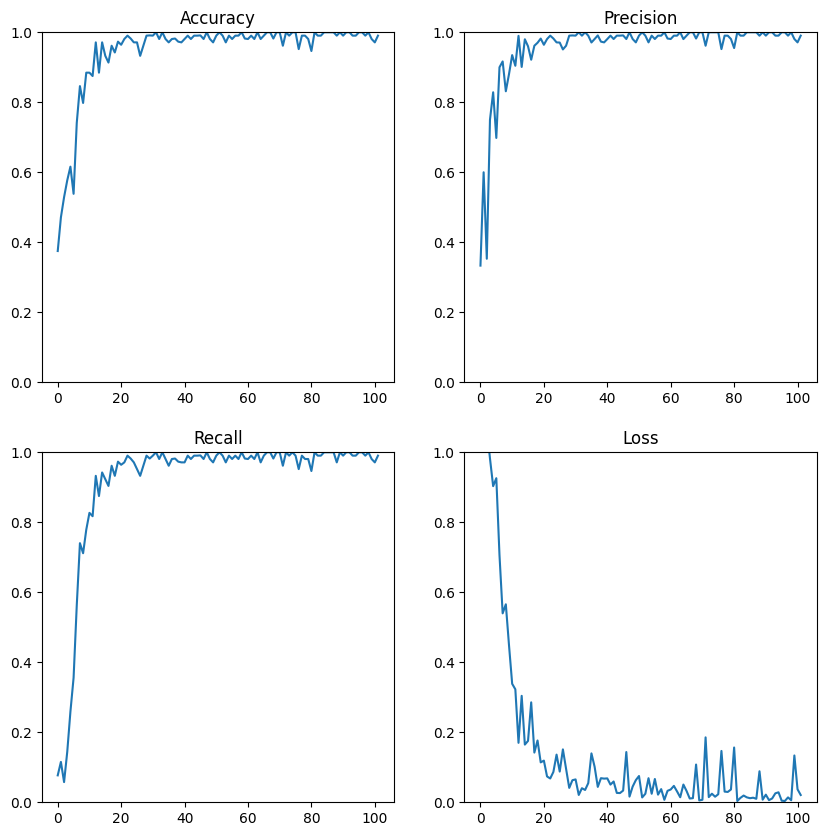

In [8]:
# plot the history of the model
plt.figure(figsize=(10, 10))

train_accuracy = history.history['accuracy']
train_precision = history.history['precision']
train_recall = history.history['recall']
train_auc = history.history['loss']

plt.subplot(2, 2, 1)
plt.plot(train_accuracy, label='train_accuracy')
plt.ylim([0, 1])
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(train_precision, label='train_precision')
plt.ylim([0, 1])
plt.title('Precision')

plt.subplot(2, 2, 3)
plt.plot(train_recall, label='train_recall')
plt.ylim([0, 1])
plt.title('Recall')

plt.subplot(2, 2, 4)
plt.plot(train_auc, label='train_loss')
plt.ylim([0, 1])
plt.title('Loss')

plt.show()

# Evaluation

In [9]:
model.evaluate(train_generator)

8/8 [==============================] - 3s 393ms/step - loss: 0.0227 - accuracy: 0.9917 - precision: 0.9917 - recall: 0.9917


[0.0226609967648983,
 0.9916666746139526,
 0.9916666746139526,
 0.9916666746139526]

In [ ]:
all_images = glob.glob('data/*/*.jpg')
all_images = [img.replace('\\', '/') for img in all_images]
class_names = [img.split('/')[-2] for img in all_images]


# Inference

In [4]:
model = tf.keras.models.load_model('sea_cucumber_detector.h5')
model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),       
            loss='categorical_crossentropy',
            metrics=[
                tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ])

In [13]:
class_dict = train_generator.class_indices
class_dict_rev = {v: k for k, v in class_dict.items()}

all_images = glob.glob('data/*/*.*')
all_images = [img.replace('\\', '/') for img in all_images]
all_labels = [img.split('/')[-2] for img in all_images]
all_img_names = [img.split('/')[-1].split('.')[0] for img in all_images]

img2label = dict(zip(all_img_names, all_labels))

In [19]:
class_dict_rev = {0: 'Adult', 1: 'BigJuveniles', 2: 'MediumJuveniles', 3: 'SmallJuveniles'}

In [22]:
def inference(model, image_path):
    image_path = image_path.replace('\\', '/')
    class_name = image_path.split('/')[-1].split('.')[0]
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, target_size)
    img = np.expand_dims(img, axis=0)
    img = preprocessing_function(img)
    prediction = model.predict(img)
    prediction = np.squeeze(prediction)
    prediction = np.argmax(prediction)
    try:
        return img2label[class_name]
    except:
        return class_dict_rev[prediction]

In [23]:
inference(
            model, 
            'data/Adult/0a9ab59a-3dae-4d9a-9b81-3ad542cc4521.jpg'
        )

1/1 [==============================] - 0s 23ms/step


'Adult'